Material informatics is a rapidly growing field, enabled by the simultaneous growth of high-performance computing and the availability of analystics software packages. The fields of materials discovery and design, hitherto belonging to the larger field of material science are now increasingly being aided by informatics techniques.

Target identification is typically the first phase of materials discovery and design. Typically, this involves a material or a set of material attributes for which a substitute needs to be found. There can be many reasons for why such a substitution is sought - to enable a cheaper product at similar or better performance, for instance. Another reason could be to improve product performance at comparable or cheaper cost.

Traditionally, the process of materials discovery and design has proceeded intuitively, based on extensive knowledge of materials gathered experimentally over the course of a few centuries. The process typically proceeds via experimental trial-and-error and it is estimated that the typical time taken to develop a new material is 20 years. The field of Material informatics aims to achieve a significant reduction in the time required to discover and develop new materials using a synthesis of experimental, computational and analytical techniques.

A number of new software packages tailored towards the broad aims of Materials Informatics have been developed in recent years. In this blog post, I will highlight two such packages - PyMatGen and MatMiner. PyMatGen is a Python based API that enables access to the Materials Project. MatMiner is a Python package that was written to convert materials information from databases such as the Materials Project to a format suitable for machine learning.

My objective in this blog post is to provide a rather straightforward example of materials discovery on the basis of the average valence electronic structure of materials. I first attempt to explain the concept of average electronic structure and its relevance to material discovery. I then outline specific questions that I attempt to answer by performing an unsupervised learning of the average electronic structure of materials in the database. Each subsequent section provides answers in the form of visualizations and tables. The last section provides key take-home messages from the analysis and some suggestions for expanding and improving upon the analysis in this post. Accompanying code for this post can be found at my repository on GitHub. 

Electronic structure:

Average electronic structure:

Questions  
1) When materials are represented on the basis of their average electronic structure, what is the optimum number of clusters that they can be grouped into?  
2) What materials are represented by cluster centers? Alternately, what unary material/materials are closest to cluster centers?   
3) Does the grouping make intuitive sense - i.e. are the cluster centers sufficiently far away from each other on the basis of chemical intuition?  
4) Given a target material, say Copper, what is the material (unary, binary and ternary respectively) whose electronic structure most closely resembles that of Copper?  
5) Given a target material, say Cobalt, what is the (binary and ternary) nitride material whose electronic structure most closely resembles that of Cobalt?  


# Question 1  

### When materials are represented on the basis of their average electronic structure, what is the optimum number of clusters that they can be grouped into? 

In [377]:
#import relevant packages
import numpy as np
import pandas as pd
import pymatgen as mg
import matplotlib.pyplot as plt
from matminer.featurizers.composition import ValenceOrbital 
from matminer.featurizers.conversions import StructureToComposition
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances,pairwise_distances_argmin
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%matplotlib inline

We first define an MPRester object that can be used to query the Materials Project.

In [378]:
#define a MPRester object
mpr = mg.MPRester(api_key='zUTBDkOXNL4RpPaQ')

Next, we create a function to fetch data from the Materials Project based on the number of elements in the material. These materials are respectively called 'unary', 'binary' and 'ternary'.

In [379]:
unary_list = mpr.get_data('*') # returns all data corresponding to mono-atomic materials in a list of dicts
unary = pd.DataFrame(unary_list)

In [380]:
binary_list = mpr.get_data('*-*') # returns all data corresponding to di-atomic materials in a list of dicts
binary = pd.DataFrame(binary_list)

For Ternary materials, the amount of data returned by the simple query ("*-*-*") is large enough that Materials Project automatically limits this transfer. To work around this limitation, we convert the problem of querying all ternary materials to a problem of querying ternary materials tagged by specific elements. This approach results in duplication of data, which can be taken care of in subsequent steps. In doinng so, heavy atoms (Lanthanides, Actinides), radioactive atoms and highly reactive (H, O, F, Cl, Br, I) or noble gases (He, Xe) were omitted from this list.

In [381]:
elem_list = ['Ag' ,'Al', 'As', 'Au', 'B', 'Be', 'Bi', 'C', 'Ca', 'Cd','Co','Cr','Cu','Fe','Ga','Ge',
             'Hf','Hg','In','Ir','K','La','Li','Mg','Mn','Mo','N','Na','Nb','Ni','Os','P','Pb','Pd',
             'Pt','Rh','Ru','S','Sb','Sc','Se','Si','Sn','Ta', 'Te','Ti','V','W','Y','Zn','Zr']

In [ ]:
ternary = pd.DataFrame()
for elem in elem_list:
    query = '*-*-'+elem #break-up query element-wise
    try:
        ternary_list = mpr.get_data(query)
        ternary = ternary.append(pd.DataFrame(ternary_list),ignore_index=True,verify_integrity=True)
    except Exception as e:
        print('Element for which we are getting this error -- {}'.format(elem))
        print(e)
        continue

In [398]:
a = [True if(set(cand_list).issubset(elem_list)) else False for cand_list in ternary['elements'].tolist()]

In [404]:
a

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 Fa

Next, the unary, binary and ternary databases are combined into a single dataset. Duplicates are removed.

In [362]:
materials_db = unary
materials_db = materials_db.append(binary,ignore_index=True,verify_integrity=True)
materials_db = materials_db.append(ternary,ignore_index=True,verify_integrity=True)
materials_db = materials_db.drop_duplicates(subset=['material_id'])

Check the number of unique materials in this dataset.

In [363]:
materials_db.shape[0]

81036

The next step is to create a PyMatGen "Composition" object (http://pymatgen.org/_modules/pymatgen/core/composition.html) for each unique material in the dataset. This step is a precursor to adding electronic structure related features to the dataset.

In [364]:
materials_db['composition'] = materials_db['pretty_formula'].apply(lambda x: mg.Composition(x))

The valence electronic structure of each material can be obtained from the ValenceOrbital Featurizer in MatMiner (https://hackingmaterials.github.io/matminer/matminer.featurizers.html#matminer.featurizers.composition.ValenceOrbital)
I am primarily interested in the 's', 'p' and 'd' orbital valence configuration

In [365]:
vo = ValenceOrbital(orbitals=['s','p','d'],props=['avg'])
materials_db = vo.featurize_dataframe(df=materials_db,col_id='composition')

To examine the output of this step it is useful to check the names of the columns that result from the featurizing operation

In [13]:
materials_db.columns

Index(['band_gap', 'cif', 'density', 'diel', 'e_above_hull', 'elasticity',
       'elements', 'energy', 'energy_per_atom', 'formation_energy_per_atom',
       'full_formula', 'hubbards', 'icsd_id', 'icsd_ids', 'is_compatible',
       'is_hubbard', 'material_id', 'nelements', 'nsites', 'oxide_type',
       'piezo', 'pretty_formula', 'spacegroup', 'tags', 'task_ids',
       'total_magnetization', 'unit_cell_formula', 'volume', 'composition',
       'avg s valence electrons', 'avg p valence electrons',
       'avg d valence electrons'],
      dtype='object')

For simplicity, it is useful to separate out the relevant features into a separate dataset and check for null values if any

In [366]:
valence_columns = ['avg s valence electrons', 'avg p valence electrons', 'avg d valence electrons']
materials_valence = materials_db[valence_columns].copy()

In [351]:
null_values = materials_valence.isnull().sum()
print(null_values)

avg s valence electrons    0
avg p valence electrons    0
avg d valence electrons    0
dtype: int64


Since there are no null values, we can continue analysis on this dataset unimpeded.

Prior to clustering, it is useful to scale the datset to ensure that no feature dominates the distance calculation

In [369]:
scaler = StandardScaler()
mat_val_scaled = scaler.fit_transform(materials_valence)

We are now in a position to perform clustering on the dataset. A simple KMeans clustering can be performed to begin with.
To determine the optimum number of clusters, we can use the Elbow Technique (). In SciKit-Learn we can plot the inertia of the clustering operation (The sum of the squared distance of each point from the closest cluster) versus the number of clusters and see if an elbow exists. If it does, we can use the elbow point to determine the optimum number of clusters. If it doesn't we may need more anaysis.

In [370]:
num_clusters  = list(range(2,20))
inertia = []
for clusters in num_clusters:
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(mat_val_scaled)
    inertia.append(kmeans.inertia_)

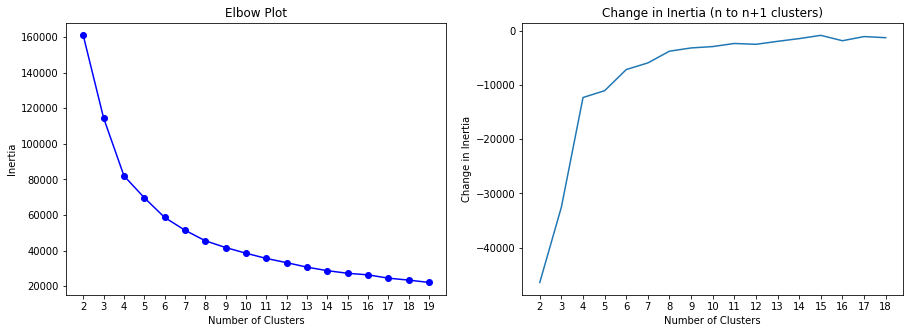

In [371]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(num_clusters,inertia,'bo-')
plt.xticks(num_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.subplot(1,2,2)
plt.plot(num_clusters[:len(num_clusters)-1],np.diff(inertia))
plt.xticks(num_clusters[:len(num_clusters)-1])
plt.xlabel('Number of Clusters')
plt.ylabel('Change in Inertia')
plt.title('Change in Inertia (n to n+1 clusters)')
plt.show()

It is difficult to visually determine if a distinct elbow exists in the inertia plot on the left. It is therefore useful to plot the rate of change of inertia when the number of clusters is increased. This plot shows a distinct 'knee' (continuing with anatomical metaphors) at n=4. 

This provides a tentative answer to question 1 - It appears that the dataset based on average electronic structure can be partitioned into 4 distinct clusters. 

# Question 2

### What materials are represented by cluster centers? Alternately, what material/materials are closest to cluster centers? 

In order to answer this question, we need to first determine what the cluster centers are for the optimum number of clusters (n=4)

In [372]:
kmeans = KMeans(n_clusters=4,random_state=42)
kmeans.fit(mat_val_scaled)
cluster_centers = kmeans.cluster_centers_

We now need a way to compare the distance of each material in the (scaled) dataset to each cluster center. Once we have this measure, we can find which material or group of materials most closely resembles the center. We can then choose this material to be (roughly) representative of its respective cluster.

The Scikit-Learn package provides such a method - pairwise_distances. Each Vector in matrix X is compared to each vector in matrix Y and a vector corresponding to the pairwise distances is returned for each Vector in Y.

In [374]:
distances = pairwise_distances(X=mat_val_scaled,Y=cluster_centers,metric='euclidean')

distances_to_centroid_1 = distances[:,0]
distances_to_centroid_2 = distances[:,1]
distances_to_centroid_3 = distances[:,2]
distances_to_centroid_4 = distances[:,3]

We can now assign these distances as columns to the original dataset and make use of the sorting functions that pandas provides in order to find the materials closest to cluster centers and print them out. In order to aid chemical intuition, we can also check which elemental materials are closest to the cluster centers. Since the properties of elemental solids are generally more familiar to people - Cu is a noble-metal, Si is a semiconductor, Na is an alkali metal for instance - it makes the comparison more accessible.

In [375]:
materials_db['distance_1'] = distances_to_centroid_1
materials_db['distance_2'] = distances_to_centroid_2
materials_db['distance_3'] = distances_to_centroid_3
materials_db['distance_4'] = distances_to_centroid_4

In [376]:
materials_db.sort_values(by='distance_1',ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_1']].head(1)

,material_id,pretty_formula,distance_1
24947,mp-1222375,Lu(MnAl)6,0.204709


Li$_2$VF$_6$ is a ternary fluoride with application for battery materials (http://www.znaturforsch.com/s68b/s68b0121.pdf)

In [288]:
materials_db.sort_values(by=['distance_2'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_2']].head(1)

,material_id,pretty_formula,distance_2
34998,mp-5046,BeSO4,0.116651


BeSO$_4$ is a large band-gap salt that was used in neutron sources for the discovery ofnuclear fission (https://en.wikipedia.org/wiki/Beryllium_sulfate)

In [338]:
materials_db.sort_values(by=['distance_3'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_3']].head(1)

,material_id,pretty_formula,distance_3
22560,mp-972511,Sm2AgSn,0.204248


In [185]:
materials_db.sort_values(by=['distance_4'],ascending=True,axis=0,inplace=True)
materials_db[['material_id','pretty_formula','distance_4']].head(1)

,material_id,pretty_formula,distance_4
9779,mp-1094645,MgGa3,0.08003


So we have Sulphur (S), Zirconium (Zr), Potassium (K) and Silver (Ag) as the elements closest to cluster centers. It's also useful to have a visual representation of this fact. Examining the periodic table it can be seen that Ag, and S are far apart from each other and from Zr and K, which are a little closer to each other.

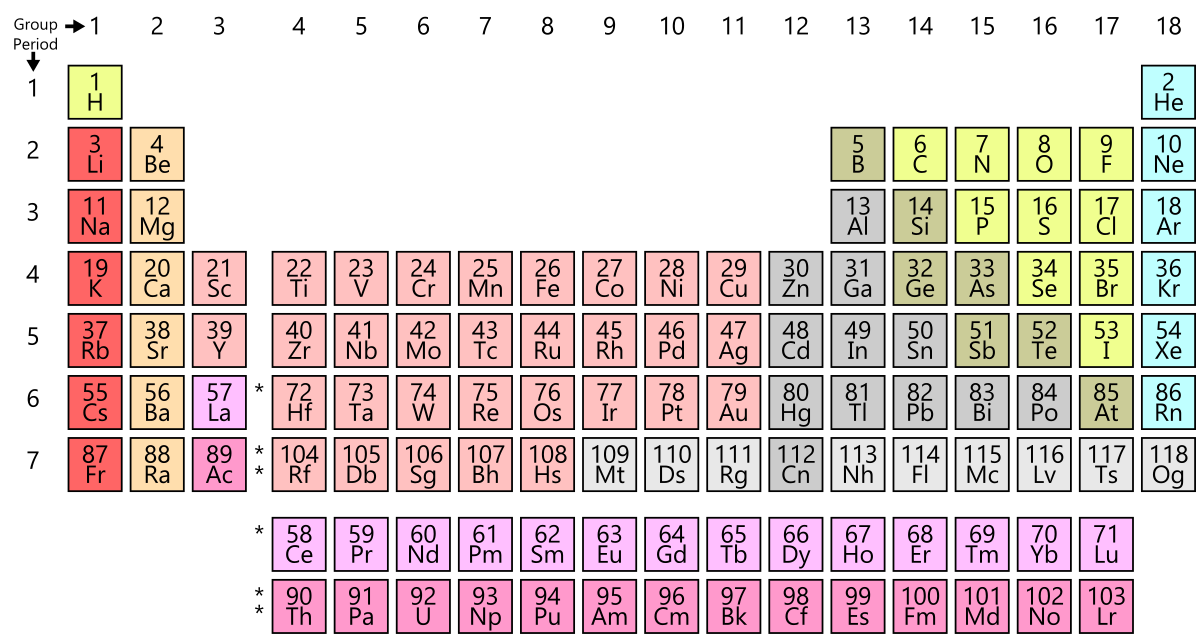

In order to get a visual representation of the clusters and the respective closest elemental materials we can project the 3 dimensional feature space two dimensions at a time

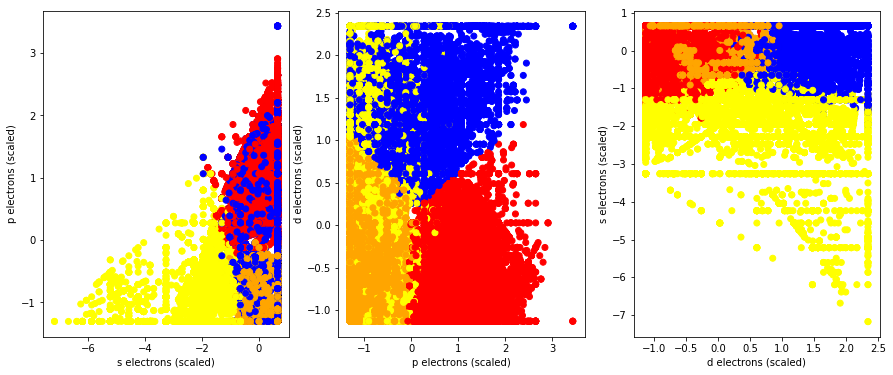

In [116]:
cluster_labels = kmeans.labels_
color_dict = {0:'orange',1:'red',2:'blue',3:'yellow'}

plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.scatter(mat_val_scaled[:,0],mat_val_scaled[:,1],color=[color_dict[label] for label in cluster_labels])
plt.xlabel('s electrons (scaled)')
plt.ylabel('p electrons (scaled)')
plt.subplot(1,3,2)
plt.scatter(mat_val_scaled[:,1],mat_val_scaled[:,2],color=[color_dict[label] for label in cluster_labels])
plt.xlabel('p electrons (scaled)')
plt.ylabel('d electrons (scaled)')
plt.subplot(1,3,3)
plt.scatter(mat_val_scaled[:,2],mat_val_scaled[:,0],color=[color_dict[label] for label in cluster_labels])
plt.xlabel('d electrons (scaled)')
plt.ylabel('s electrons (scaled)')
plt.show()                

Alternately we could project the 3 feature dimensions to two dimensions using PCA and then visualize the clusters. To compare visually the position of the above four elements (S, Zr, K and Ag) we will need to obtain the scaled coordinates of these points. We can then transform these coordinates to two dimensions using PCA and plot them on the same graph.

In [147]:
#Create a PCA object and fit and transform scaled feature matrix
pca = PCA(n_components=2)
two_d_mat_val_db = pca.fit_transform(mat_val_scaled)

#Append projected features to materials database
materials_db['proj_dim_1'] = two_d_mat_val_db[:,0]
materials_db['proj_dim_2'] = two_d_mat_val_db[:,1]

# S closest to cluster 1 has material id mp-558014
projected_S_coordinates = materials_db[materials_db['material_id']=='mp-1041451']\
                                      [['proj_dim_1','proj_dim_2']].values[0]

# Zr closest to cluster 2 has material id mp-131
projected_Zr_coordinates = materials_db[materials_db['material_id']=='mp-772958']\
                                      [['proj_dim_1','proj_dim_2']].values[0]

# K closest to cluster 3 has material id mp-1078640
projected_K_coordinates = materials_db[materials_db['material_id']=='mp-1078089']\
                                      [['proj_dim_1','proj_dim_2']].values[0]

# Ag closest to cluster 4 has material id mp-989737
projected_Ag_coordinates = materials_db[materials_db['material_id']=='mp-30721']\
                                      [['proj_dim_1','proj_dim_2']].values[0]

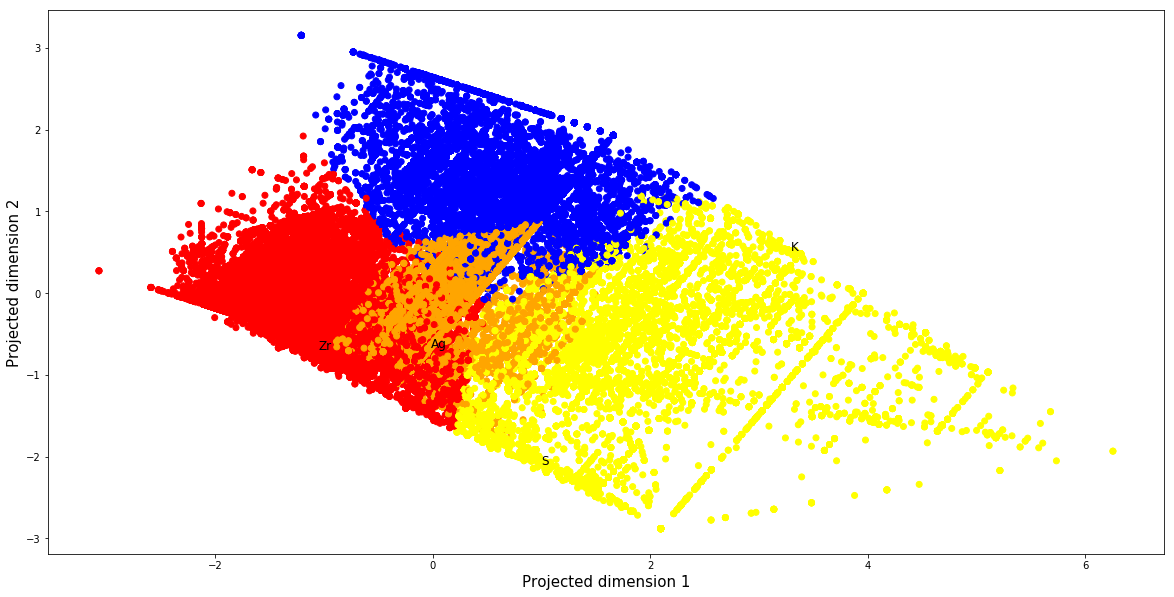

In [148]:
plt.figure(figsize=(20,10))
plt.scatter(two_d_mat_val_db[:,0],two_d_mat_val_db[:,1],color=[color_dict[label] for label in cluster_labels])

# Plot S coordinates in black
plt.text(projected_S_coordinates[0],projected_S_coordinates[1],'S',color='black',fontsize=12)

# Plot Zr coordinates in black
plt.text(projected_Zr_coordinates[0],projected_Zr_coordinates[1],'Zr',color='black',fontsize=12)
         
# Plot K coordinates in black
plt.text(projected_K_coordinates[0],projected_K_coordinates[1],'K',color='black',fontsize=12)
         
# Plot Ag coordinates in black
plt.text(projected_Ag_coordinates[0],projected_Ag_coordinates[1],'Ag',color='black',fontsize=12)

plt.xlabel('Projected dimension 1',fontsize=15)
plt.ylabel('Projected dimension 2',fontsize=15)
plt.show()

Before clustering materials, it is useful to scale the features of the dataset. Since clustering is performed based on the notion of distance and the most common distance metric is Euclidean, it is good practice to scale all dimensions so that no single contribution dominates the distance computation.

Having scaled all features, we perform KMeans clustering, treating the number of clusters as a parameter. The inertia of a particular clustering instance is defined to be the sum of the squared distances of all points from their  respective cluster center. We can expect this number to steadily  decrease as we increase the number of clusters. In the extreme case, if we setr the number of clusters to equal the number of datapoints, we get an inertia of zero, but we've basically learned nothing at all about the dataset!

Aas a compromise, a technique often referred to as the Elbow technique (https://en.wikipedia.org/wiki/Elbow_method_(clustering)) is typically utilized to find an optimum number of clusters for a particular problem. While the original technique pertained to total variance, we can use a modification of this technique to account for inertia in a similar fashion. The optimum number of clusters is the point in the inertia versus number of clusters graph shows an 'elbow' or an abrupt reduction in slope. Not every clustering problem has a well defined elbow, but we can check to see if ours does.

In [ ]:
# Drop material_id from the db before performing scaling
fingerprint_db_numeric = fingerprint_db.drop(columns=['material_id','pretty_formula','spacegroup'],axis=1)

# Perform scaling
scaled_fingerprints_database, scaler = scale_fingerprints_database(fingerprints_db=fingerprint_db_numeric)

kmeans_inertia(scaled_fingerprints_database,
               n_cluster_min=2,
               n_cluster_max=20,
               random_state=42)

It is clear that a sharp reduction in slope occurs at n=3 clusters and this is perhaps what we should use as an optimum.
Another useful way to estimate an optimum number of clusters needed is to reduce the dimensionality of the dataset so that we can visually inspect to see if there is a distinct separation between sets of points in 2D/3D space.

In order to do this, we first cluster the scaled dataset and find cluster labels. We then perform a dimensionality reduction on the scaled dataset so that our dataset now contains 2 dimensions and the dataset can be plotted as a scatter plot. If we then color each point based on their cluster label we can begin to try and see if there is a clustering that is optimum in terms of distance between individual clusters.

Instead of doing this for n=2 through 20 as we did for the Elbow method, we could simply do it to decide if we need to use 2 through 5 clusters, since that range seems to be where most of the reduction in inertia happens.

In [ ]:
# Map cluster label to color
color_dict = {0:'orange',1:'blue',2:'black',3:'yellow',4:'red',5:'gray'}

#Plot  clusters by reducing fingerprint DB dimensions to 2
plt.figure(figsize=(15,15)) 
for n_clusters in range(2,7):
    kmeans_obj = KMeans(n_clusters=n_clusters,random_state=42)
    kmeans_obj.fit(scaled_fingerprints_database)
    cluster_labels = kmeans_obj.labels_
    proj_2d_fingerprints = perform_nD_projection(fingerprints_db=scaled_fingerprints_database,n_dimensions=4)
    plt.subplot(2,3,n_clusters-1)
    plt.scatter(proj_2d_fingerprints[:,0],
                proj_2d_fingerprints[:,2],
                color = [color_dict[cluster_label] for cluster_label in cluster_labels])
    plt.xlabel('Fingerprint Projected Dimension 1')
    plt.ylabel('Fingerprint Projected Dimension 2')
    plt.title('Number of clusters = {}'.format(n_clusters))

From the figure it is apparent that for n=2 and 3 there is minimal overlap between clusters. Combining the visuals with the inertia plot above, we can settle on n=3 as an optimum number of clusters. Having done this, we should first create a clustering object using n=3 so that we can use it later for a more detailed analysis.

In [ ]:
kmeans_opt = KMeans(n_clusters=3,random_state=42)
kmeans_opt.fit(scaled_fingerprints_database)

In [ ]:
fingerprint_db = get_fingerprint_db(dbtype='unary',fingerprint_name='GRDF',stats=('mean')) #Create fingerprint DB for elemental materials from the Materials Project

In [ ]:
fingerprint_db_copy = fingerprint_db.copy()
n_closest_materials(material_id='mp-30',fingerprint_db=fingerprint_db_copy,fingerprint_name='GRDF',stats=('mean'),num_closest=30)